In [3]:
from IPython.display import Image

image_url = 'https://www.researchgate.net/profile/Noha-Radwan-3/publication/334170752/figure/fig5/AS:776225345785857@1562077952441/A-schematic-illustration-of-the-DenseNet-121-architecture-82.png'
print("DenseNet architecture")
Image(url=image_url,height=2000)

DenseNet architecture


In [12]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchview import draw_graph

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [34]:
model_parameters={}
model_parameters['densenet121'] = [6,12,24,16]
model_parameters['densenet169'] = [6,12,32,32]
model_parameters['densenet201'] = [6,12,48,32]
model_parameters['densenet264'] = [6,12,64,48]

# growth rate
k = 32
compression_factor = 0.5

In [14]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.batchNorm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=4*k, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.batchNorm2 = nn.BatchNorm2d(4*k)
        self.conv2 = nn.Conv2d(in_channels=4*k, out_channels=k, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x_in = x 
        
        x = self.batchNorm1(x)
        x = self.relu(x)
        x = self.conv1(x)
        
        x = self.batchNorm2(x)
        x = self.relu(x)
        x = self.conv2(x)
        
        x = torch.cat([x_in, x], dim=1)
        return x

In [18]:
x = torch.randn(1,64,224,224)
model = DenseLayer(64)
print('DenseLayer Output shape : ',model(x).shape)

DenseLayer Output shape :  torch.Size([1, 96, 224, 224])


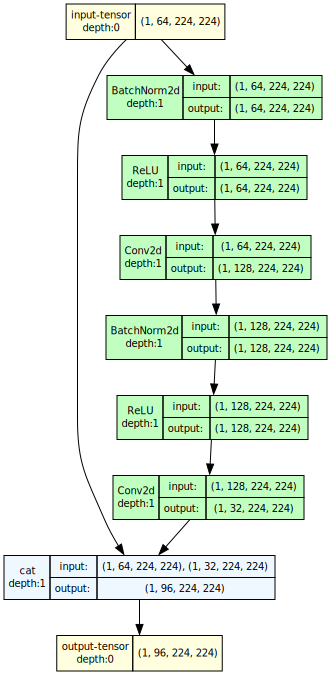

In [16]:
architecture = 'denselayer'
model_graph = draw_graph(model, input_size=(1,64,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

In [26]:
class DenseBlock(nn.Module):
    def __init__(self, layer_num, in_channels):
        super().__init__()
        
        self.layer_num = layer_num
        self.deep_nn = nn.ModuleList()
        
        for num in range(self.layer_num):
            self.deep_nn.add_module(f"DenseLayer_{num}", DenseLayer(in_channels+k*num))
            
            
    def forward(self, x):
        for layer in self.deep_nn:
            x = layer(x)
        return x

In [27]:
x = torch.randn(1,3,224,224)
model = DenseBlock(layer_num=3, in_channels=3)
print('Denseblock Output shape : ',model(x).shape)

Denseblock Output shape :  torch.Size([1, 99, 224, 224])


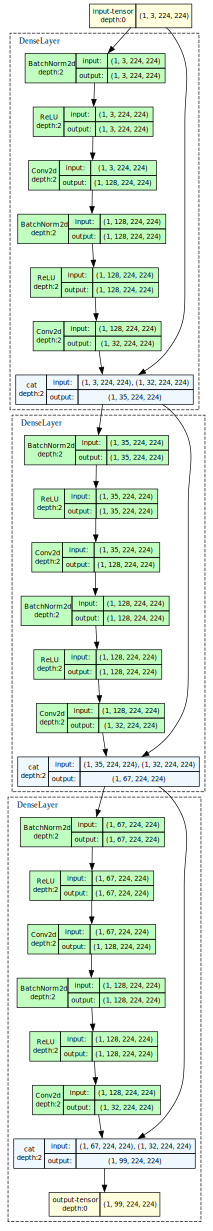

In [28]:
architecture = 'denseblock'
model_graph = draw_graph(model, input_size=(1,3,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

In [29]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, compression_factor):
        super().__init__()
        
        self.batchNorm = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels = int(in_channels*compression_factor), kernel_size=1, stride=1, padding=0, bias=False)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.batchNorm(x)
        x = self.conv(x)
        x = self.avgpool(x)
        return x

In [30]:
x = torch.randn(1,64,224,224)
model = TransitionLayer(64,compression_factor)
print('Transition Layer Output shape : ',model(x).shape)

Transition Layer Output shape :  torch.Size([1, 32, 112, 112])


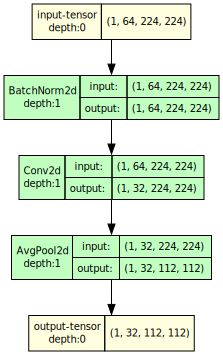

In [31]:
architecture = 'transition'
model_graph = draw_graph(model, input_size=(1,64,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

In [55]:
class DenseNet(nn.Module):
    def __init__(self, densenet_variant, in_channels, num_classes=1000):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batchNorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.deep_nn = nn.ModuleList()
        dense_block_inchannels = 64
        
        for num in range(len(densenet_variant))[:-1]:
            self.deep_nn.add_module(f"DenseBlock_{num+1}", DenseBlock(densenet_variant[num], dense_block_inchannels))
            dense_block_inchannels = int(dense_block_inchannels + k * densenet_variant[num])
            
            self.deep_nn.add_module(f"TranzitionLayer_{num+1}", TransitionLayer(dense_block_inchannels, compression_factor))
            dense_block_inchannels = int(dense_block_inchannels * compression_factor)
            
        self.deep_nn.add_module(f"DenseBlock_{num+2}", DenseBlock(densenet_variant[-1], dense_block_inchannels))
        dense_block_inchannels = int(dense_block_inchannels + k* densenet_variant[-1])
        
        self.batchNorm2 = nn.BatchNorm2d(dense_block_inchannels)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(dense_block_inchannels, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        
        
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        for layer in self.deep_nn:
            x = layer(x)
            
        x = self.batchNorm2(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [60]:
x = torch.randn(1,3,224,224)
model = DenseNet(model_parameters['densenet121'],3)
print('DenseNet Layer Output shape : ',model(x).shape)

DenseNet Layer Output shape :  torch.Size([1, 1000])


In [58]:
architecture = 'denseNet'
model_graph = draw_graph(model, input_size=(1,3,224,224), graph_dir ='TB' , roll=False, expand_nested=True, show_shapes=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph